In [1]:
from tensorflow.keras.utils import load_img, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

from sklearn.svm import OneClassSVM
from glob import glob
import pandas as pd
import numpy as np

2023-02-05 19:37:43.319365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 19:37:43.412532: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-05 19:37:43.415201: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 19:37:43.415226: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [5]:
# Load the MovileNetV2 model with imagenet weights. Specify the input shape to be a multiple of the standard image size and grayscale.

base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

In [8]:
# Create a new model on top
inputs = tf.keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
outputs = tf.keras.layers.GlobalAveragePooling2D()(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
# images = np.stack([np.array(load_img(fname)) for fname in fnames[:100]])
images = image_dataset_from_directory(
    directory='images_007/',
    labels=None,
    shuffle=False,
    image_size=(224,224),
    interpolation='bicubic')

Found 10000 files belonging to 1 classes.


In [13]:
X = model.predict(images)

313/313 [==============================] - 109s 346ms/step


Train a one-class SVM and see if I can tune the parameters to get a more coherent result.

In [17]:
clf = OneClassSVM(nu=0.01, kernel='poly', degree=5)
y_pred = clf.fit_predict(X)

In [18]:
df = pd.DataFrame({
    'fname':images.file_paths,
    'y_pred':y_pred
})
df.head()

,fname,y_pred
0,images_007/images/00013774_026.png,1
1,images_007/images/00013774_027.png,1
2,images_007/images/00013774_028.png,1
3,images_007/images/00013774_029.png,1
4,images_007/images/00013774_030.png,1


In [19]:
df['y_pred'].value_counts()

 1    9900
-1     100
Name: y_pred, dtype: int64

In [20]:
df[df['y_pred']==-1].sample(5)

,fname,y_pred
458,images_007/images/00013894_027.png,-1
8746,images_007/images/00015732_027.png,-1
8178,images_007/images/00015606_024.png,-1
3179,images_007/images/00014392_001.png,-1
5758,images_007/images/00015007_003.png,-1


In [21]:
df[df['y_pred']==1].sample(5)

,fname,y_pred
1406,images_007/images/00014030_000.png,1
567,images_007/images/00013917_002.png,1
69,images_007/images/00013782_004.png,1
1861,images_007/images/00014128_029.png,1
1441,images_007/images/00014034_007.png,1


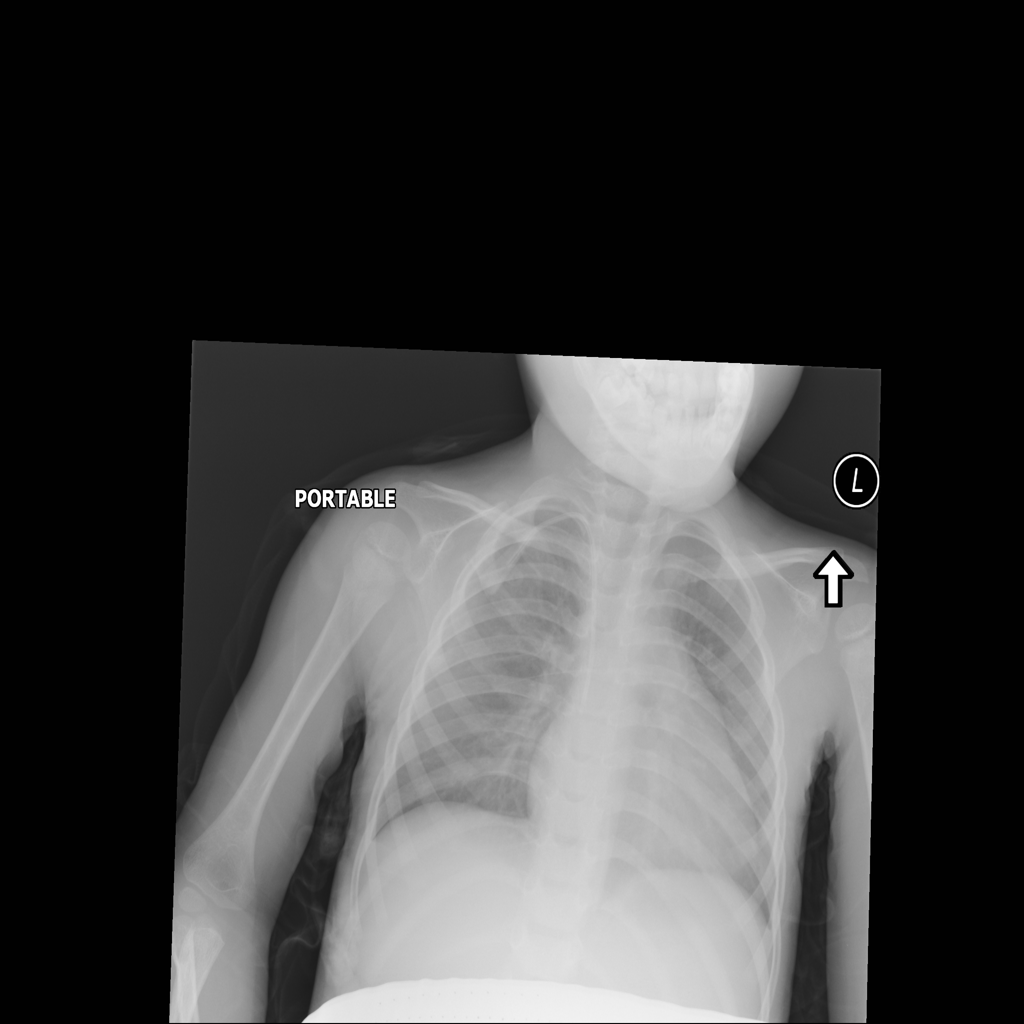

In [26]:
load_img(images.file_paths[5758])